In [21]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SEIR_model import *
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [22]:
%%time
## Update data from DXY
! cd ../data_processing && python DXY_AreaData_query.py

2020-02-14 18:43:09Update records successfully to ../data/DXY_Chinese.csv
Save area daily dataset (English) into ../data/DXYArea.csv
CPU times: user 255 ms, sys: 96.9 ms, total: 352 ms
Wall time: 18.1 s


### Load data and clean data

In [27]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")
"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)

In [30]:
## Dataset preperation
df['R'] = df['cured'] + df['dead']
SIR_data = df[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})
#SIR_data.tail(3)

In [31]:
# China total
China_df = SIR_data[SIR_data['date'] > datetime.datetime(2020, 1, 14)] 
China_total = get_China_total(China_df)
China_total.tail(3)

,date,Days,countryCode,province,city,I,E,R
6091,2020-02-11,65,CN,NaN,NaN,38874,16067,5856
6436,2020-02-12,66,CN,NaN,NaN,51933,13435,6906
6781,2020-02-13,67,CN,NaN,NaN,55823,10109,8109


### Estimate China Total

In [32]:
Dynamic_SEIR1 = Train_Dynamic_SEIR(epoch = 10000, data = China_total, 
                 population = 1400000000, rateAl = 1/7, rateIR=1/14)

In [33]:
estimation_df = Dynamic_SEIR1.train() 
est_beta = Dynamic_SEIR1.rateSI
est_alpha = Dynamic_SEIR1.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR1.numIndividuals

The loss in is 1475658.7852040816
The MAPE in is 0.08857802983010848
Optimial beta is 2.6379381643882342e-05


In [34]:
estimation_df.tail(2)

,Time,Estimated_Susceptible,Estimated_Exposed,Estimated_Infected,Estimated_Resistant
28,28.0,1.399928e+09,11517.584252,50142.785714,10615.500000
29,29.0,1.399926e+09,8666.329641,53279.785714,12096.357143


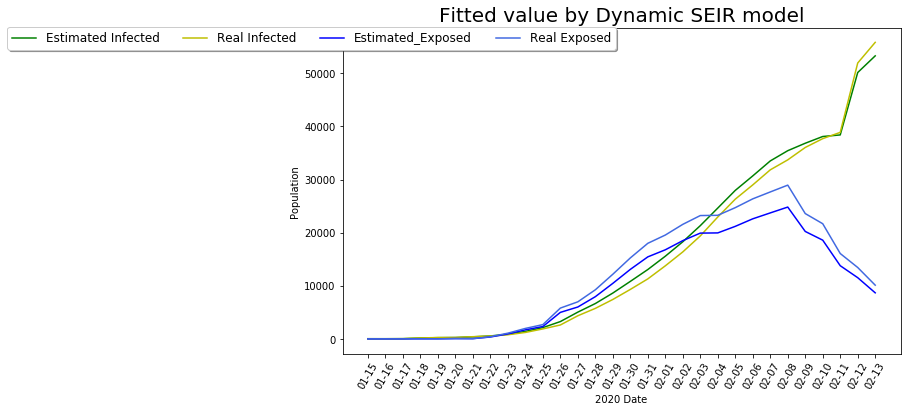

In [35]:
Dynamic_SEIR1.plot_fitted_result(China_total)

In [36]:
## use the last observation as the initial point in the new SEIR model

I0 = list(China_total['I'])[-1]
R0 = list(China_total['R'])[-1]
E0 = list(China_total['E'])[-1]
S0 = population - I0 - E0 - E0

Maximum infected case:  55823


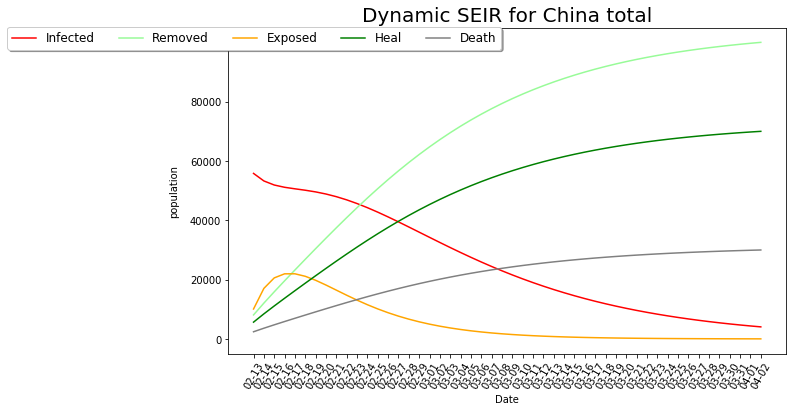

In [38]:
seir_new = dynamic_SEIR(eons=50, Susceptible=S0, Exposed = E0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    rateAl = 1/7, alpha = est_alpha, c = est_c, b = est_b)
result = seir_new.run(death_rate = 0.3)
seir_new.plot_noSuscep('Dynamic SEIR for China total', 'population', 'Date', starting_point = China_total['date'].max())

### Estimate Hubei

### Estimate Ex-Hubei

The loss in is 3438757.948129251
The MAPE in is nan
Optimial beta is 3.671960655291781e-05


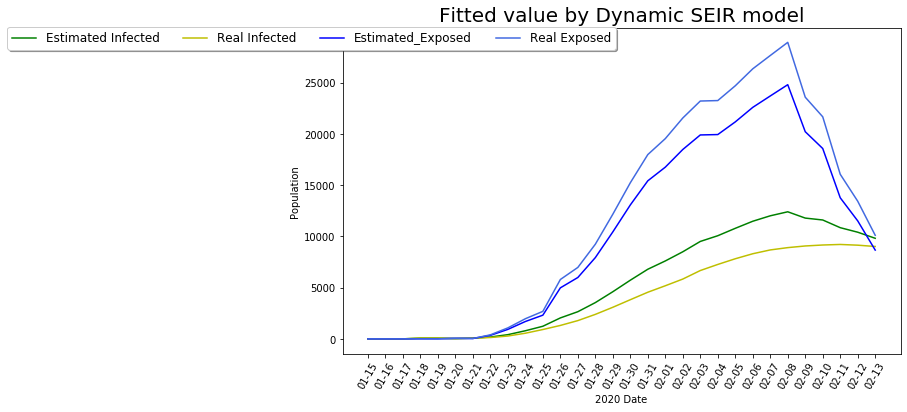

Maximum infected case:  13354


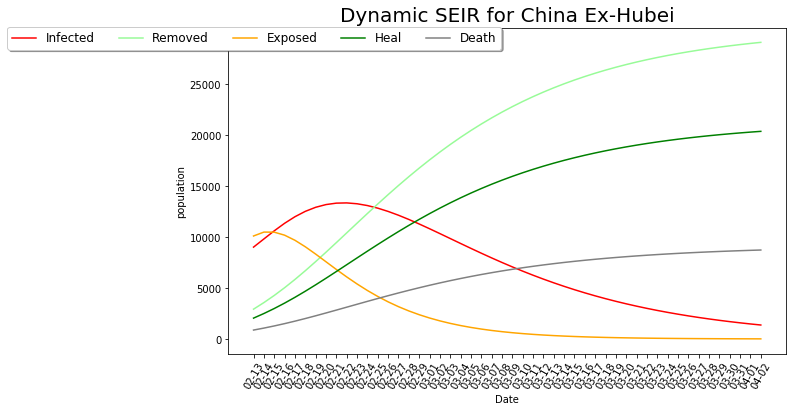

In [39]:
NotHubei = get_China_exclude_province(China_df, "Hubei Province")

Dynamic_SEIR1 = Train_Dynamic_SEIR(epoch = 10000, data = NotHubei, 
                 population = 1300000000, rateAl = 1/7, rateIR=1/14)

estimation_df = Dynamic_SEIR1.train() 
est_beta = Dynamic_SEIR1.rateSI
est_alpha = Dynamic_SEIR1.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR1.numIndividuals

# Draw fitted result
Dynamic_SEIR1.plot_fitted_result(NotHubei)

## use the last observation as the initial point in the new SEIR model
I0 = list(NotHubei['I'])[-1]
R0 = list(NotHubei['R'])[-1]
E0 = list(NotHubei['E'])[-1]
S0 = population - I0 - E0 - E0

seir_new = dynamic_SEIR(eons=50, Susceptible=S0, Exposed = E0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    rateAl = 1/7, alpha = est_alpha, c = est_c, b = est_b)
result = seir_new.run(death_rate = 0.3)
seir_new.plot_noSuscep('Dynamic SEIR for China Ex-Hubei', 'population', 'Date', starting_point = China_total['date'].max())